In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
"""
outputted:

Loaded 81460 rows and 35 columns from accepted_loans_ml_training
Label distribution (is_default):
is_default
0    71365
1    10095
Name: count, dtype: int64 

Numeric features: ['loan_amnt', 'funded_amnt', 'term_months', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'total_acc', 'revol_bal', 'revol_util', 'pub_rec_bankruptcies']
Categorical features: ['purpose', 'application_type', 'activity_year', 'action_taken', 'preapproval', 'loan_to_value_ratio', 'total_loan_costs', 'derived_loan_product_type', 'loan_purpose', 'home_ownership', 'verification_status', 'income', 'debt_to_income_ratio', 'applicant_credit_score_type', 'co_applicant_credit_score_type']
Train size: (65168, 31)
Test size: (16292, 31)

=== Training model ===
Training complete.

=== Evaluation on TEST set ===

Classification report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     14273
           1       0.57      0.00      0.00      2019

    accuracy                           0.88     16292
   macro avg       0.72      0.50      0.47     16292
weighted avg       0.84      0.88      0.82     16292

Confusion matrix (rows=true, cols=pred):
[[14270     3]
 [ 2015     4]]

y = df["is_default"] -> Dependent variable
X = df.drop(columns=["is_default", "loan_id", "borrower_id", "loan_status"]) -> Independent variables
    -> Note these columns are dropped since they are used to identify entries, DO NOT have impact on actual data processing

"""

In [3]:
from sqlalchemy import create_engine
import numpy as np

def load_training_data(db_url = "postgresql+psycopg2:///credit_risk", NAME = str) -> pd.DataFrame:
    engine = create_engine(db_url)
    df = pd.read_sql(f"SELECT * FROM {NAME}", engine)

    print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns from {NAME}")
    return df


In [4]:
accepted_loans = load_training_data(NAME="accepted_loans")
accepted_loans.dtypes

Loaded 281877 rows and 20 columns from accepted_loans


loan_id                                    int64
borrower_id                                int64
loan_amnt                                float64
funded_amnt                              float64
term_months                                int64
int_rate                                 float64
installment                              float64
income                                   float64
dti                                      float64
loan_status                               object
purpose                                   object
application_type                          object
activity_year                            float64
action_taken                             float64
preapproval                              float64
loan_to_value_ratio                      float64
total_loan_costs                          object
derived_loan_product_type                 object
loan_purpose                              object
created_at                   datetime64[ns, UTC]
dtype: object

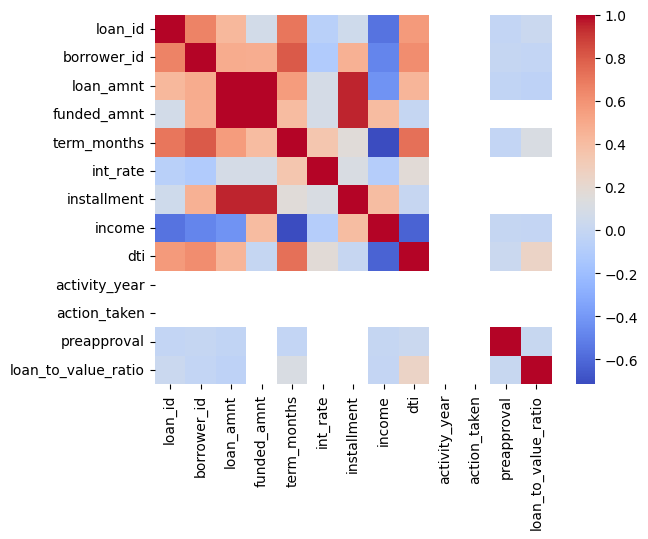

In [7]:
import seaborn as sns

numeric_cols = accepted_loans.select_dtypes(include='number')
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', annot=False)
plt.show()

#Shows the relationship and how strong 2 particular values have (red means pos relation, blue means neg)

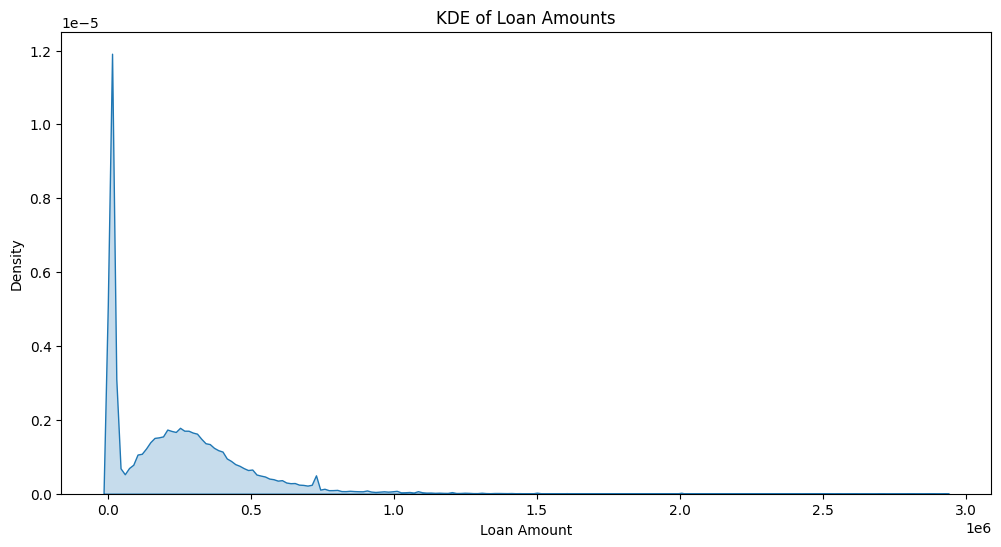

In [6]:
#Shows the number of loans approved according to loan amount
plt.figure(figsize=(12,6))
sns.kdeplot(accepted_loans['loan_amnt'], fill=True, bw_adjust=0.25)
plt.title("KDE of Loan Amounts")
plt.xlabel("Loan Amount")
plt.ylabel("Density")
plt.show()

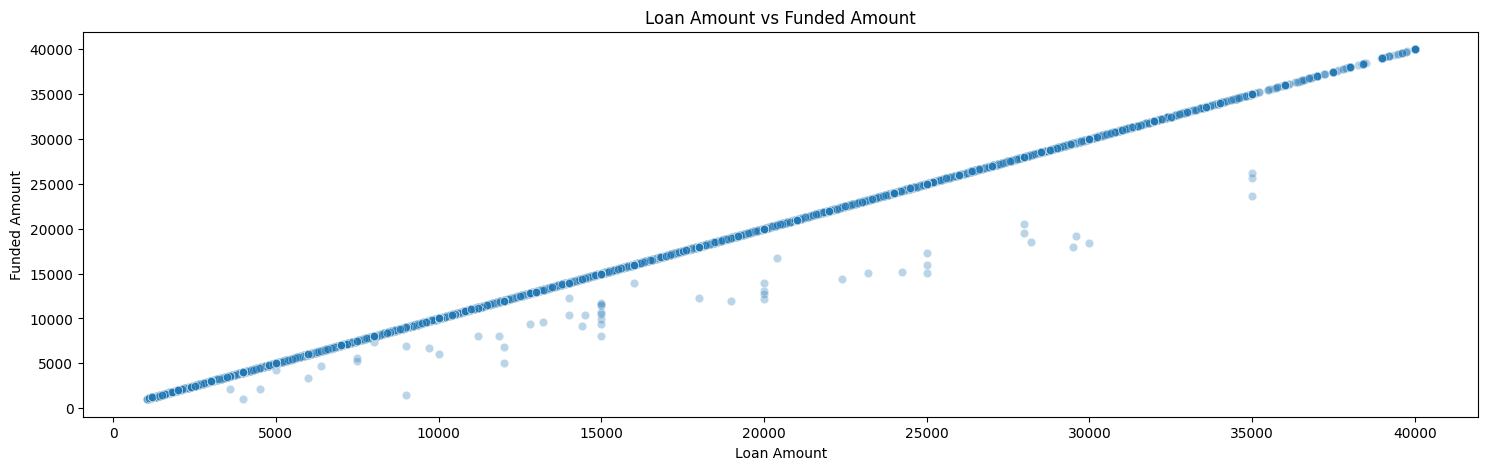

In [ ]:
plt.figure(figsize=(18,5))

# Loan Amount vs Funded Amount
sns.scatterplot(data=accepted_loans, x='loan_amnt', y='funded_amnt', alpha=0.3)
plt.title('Loan Amount vs Funded Amount')
plt.xlabel("Loan Amount")
plt.ylabel("Funded Amount")
plt.show()

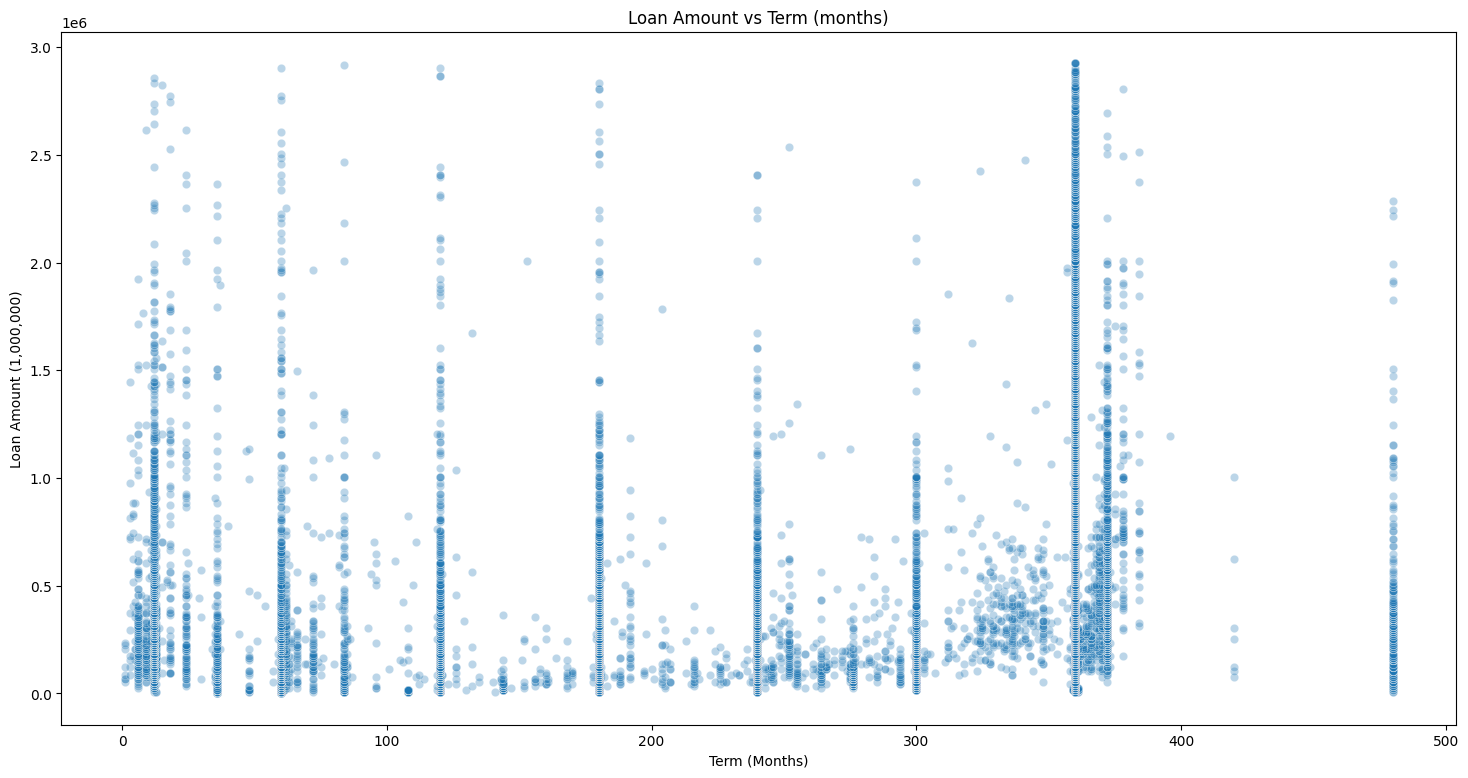

In [8]:
# Loan Amount vs Installment Amount
plt.figure(figsize=(18,9))
sns.scatterplot(data=accepted_loans, x='term_months', y='loan_amnt', alpha=0.3)
plt.title('Loan Amount vs Term (months)')
plt.xlabel("Term (Months)")
plt.ylabel("Loan Amount (1,000,000)")
plt.show()

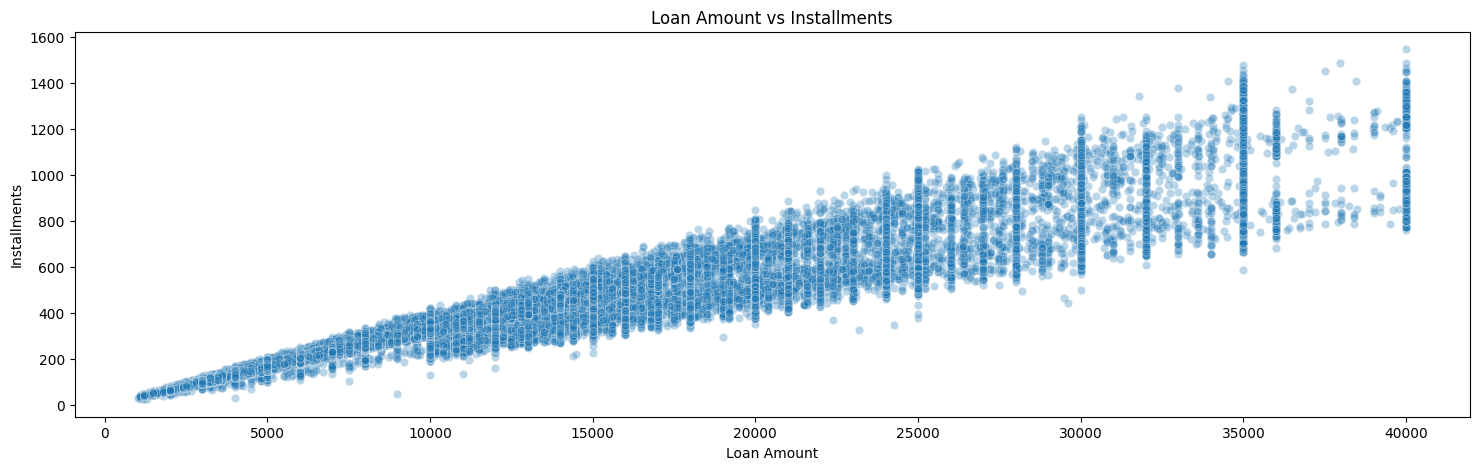

In [12]:
# Loan Amount vs Installment Amount
plt.figure(figsize=(18,5))
sns.scatterplot(data=accepted_loans, x='loan_amnt', y='installment', alpha=0.3)
plt.title('Loan Amount vs Installments')
plt.xlabel("Loan Amount")
plt.ylabel("Installments")
plt.show()

220000.0


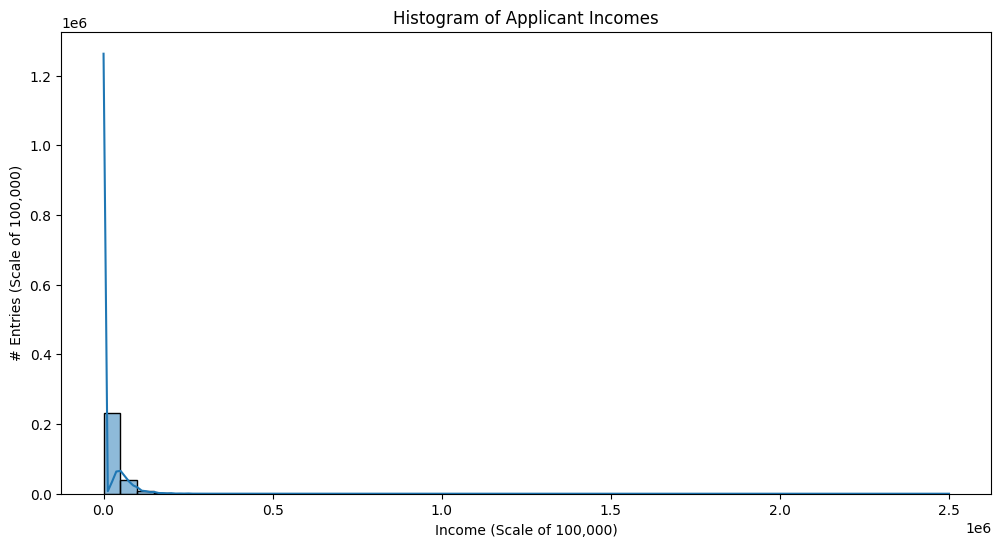

In [57]:
#Shows the number of loans approved according to loan amount
#accepted_loans = accepted_loans[accepted_loans['income'] <= 220000]

print(accepted_loans['income'].quantile(0.997))
plt.figure(figsize=(12,6))
sns.histplot(accepted_loans['income'], kde=True, bins=50)
plt.title("Histogram of Applicant Incomes")
plt.xlabel("Income (Scale of 100,000)")
plt.ylabel("# Entries (Scale of 100,000)")
plt.show()

**Loan Amount VS Funded Amount**
- Almost all the loans are funded for the exact amount requested
- Both Loan amount and funded amount don't need to be used in the ML model, only one since the values are so close

**Loan Amount vs Installment**
- Installments scale with loan amount (expected)
- Loans are being issued under a specific set of terms

**DTI vs Term Length**
- DTI does not relate much to term length
- Most DTI levels have similar term lengths

**Histogram of Applicant Incomes**
- The graph shows that most of our entries fall under 500,000
- We will use the 99th percentile income cap to filter out extreme outliers

**Approved DTIs**
- This shows where the majority of the approved dti (debt-to-income) ratios fall into

***GRAPHS USED TO COMPARE ML DATA***

In [20]:
versus = pd.DataFrame({
    "model": ["Logistic Regression","Random Forest","Gradient Boosting"],
    "accuracy": [0.6581,0.8733,0.4593],
    "precision_1": [0.1819,0.2472,0.1596],
    "recall_1": [0.5027,0.0109,0.7885],
    "f1_1": [0.2671,0.0209,0.2655],
    "roc_auc": [0.6419,0.5979,0.6568]
})

versus

,model,accuracy,precision_1,recall_1,f1_1,roc_auc
0,Logistic Regression,0.6581,0.1819,0.5027,0.2671,0.6419
1,Random Forest,0.8733,0.2472,0.0109,0.0209,0.5979
2,Gradient Boosting,0.4593,0.1596,0.7885,0.2655,0.6568


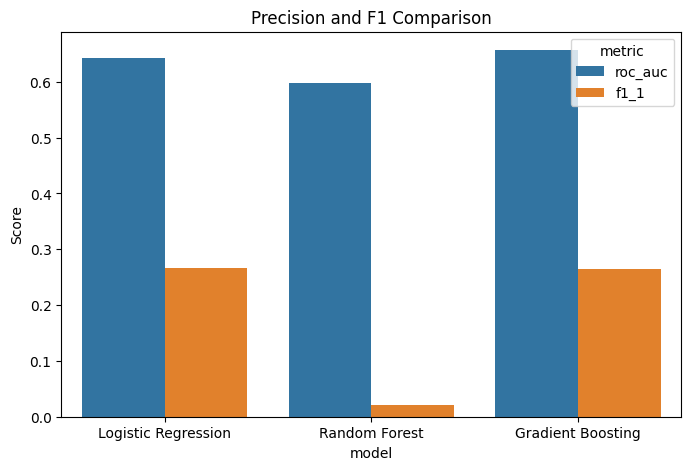

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

#makes the bar graph to compare precision and f1 scores of all models
melted = versus.melt(id_vars="model", value_vars=["roc_auc", "f1_1"], var_name="metric", value_name="score")

plt.figure(figsize=(8,5))
sns.barplot(data=melted, x="model", y="score", hue="metric")
plt.title("Precision and F1 Comparison")
plt.ylabel("Score")
plt.show()

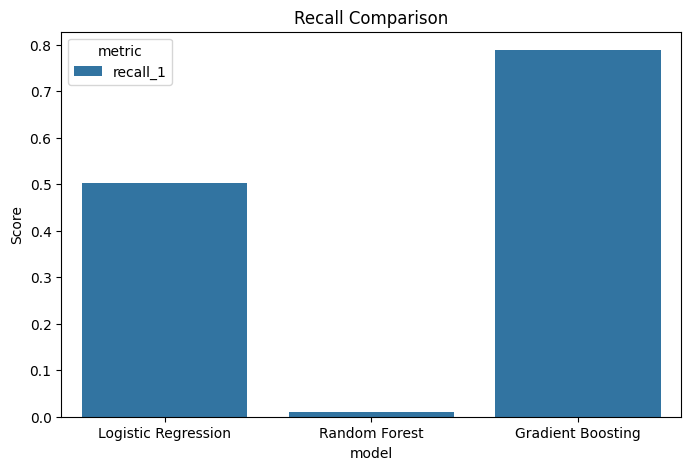

In [22]:
melted2 = versus.melt(id_vars="model", value_vars=["recall_1"], var_name="metric", value_name="score")

plt.figure(figsize=(8,5))
sns.barplot(data=melted2, x="model", y="score", hue="metric")
plt.title("Recall Comparison")
plt.ylabel("Score")
plt.show()